Linear Regression Model


In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import LinearRegression
from sklearn.metrics          import mean_squared_error, mean_absolute_error, r2_score

def find_csv(filename: str) -> pathlib.Path:
    """Look for filename in project root and in Datasets/."""
    candidates = [
        pathlib.Path(filename),
        pathlib.Path("Datasets") / filename
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Could not find {filename} in root or Datasets/")

def load_season_averages():
    folder = pathlib.Path("Datasets") / "NBA dataset 23-24 (NEW)"
    if not folder.exists():
        raise FileNotFoundError(f"{folder} not found.")
    dfs = []
    for f in folder.glob("*.csv"):
        df = pd.read_csv(f)
        if "Player" in df.columns:
            df = df.rename(columns={"Player": "PLAYER_NAME"})
        dfs.append(df)
    season_df = pd.concat(dfs, ignore_index=True)
    return season_df.rename(columns={
        "MP":   "MP_per_game",
        "PTS":  "PTS_per_game",
        "AST":  "AST_per_game",
        "TRB":  "TRB_per_game",
        "eFG%": "eFG_pct"
    })[["PLAYER_NAME","MP_per_game","PTS_per_game","AST_per_game","TRB_per_game","eFG_pct"]]

def train_model():
    # Load shot-chart data
    shot_path = find_csv("23-24 NBA dataset.csv")
    nba_df = pd.read_csv(shot_path)
    for c in ['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']:
        nba_df[c] = nba_df[c].astype(int)
    for c in ['SHOT_TYPE','PLAYER_NAME','TEAM_NAME','HOME_TEAM_NAME','AWAY_TEAM_NAME','LOCATION']:
        nba_df[c] = nba_df[c].astype(str)

    nba_df['OPPONENT_TEAM'] = np.where(
        nba_df['TEAM_NAME']==nba_df['HOME_TEAM_NAME'],
        nba_df['AWAY_TEAM_NAME'],
        nba_df['HOME_TEAM_NAME']
    )
    nba_df['home_flag'] = (nba_df['LOCATION']=='Home').astype(int)

    shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG']==1].copy()
    shots['POINTS'] = np.where(
        (shots['SHOT_MADE_FLAG']==1)&(shots['SHOT_TYPE']=='3PT'), 3,
        np.where(shots['SHOT_MADE_FLAG']==1, 2, 0)
    )

    # First-half summary
    fh = shots[shots['PERIOD'].isin([1,2])]
    first_half = fh.groupby(
        ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM']
    ).agg(
        first_half_attempts=('SHOT_ATTEMPTED_FLAG','sum'),
        first_half_made     =('SHOT_MADE_FLAG','sum'),
        first_half_points   =('POINTS','sum'),
        first_half_fg_pct   =('SHOT_MADE_FLAG', lambda s: s.sum()/len(s) if len(s)>0 else 0),
        avg_shot_distance   =('SHOT_DISTANCE','mean'),
        pct_3pt_attempts    =('SHOT_TYPE', lambda s:(s=='3PT').mean()),
        home_flag           =('home_flag','max')
    ).reset_index()

    # Second-half summary
    sh = shots[shots['PERIOD'].isin([3,4])]
    second_half = sh.groupby(
        ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM']
    ).agg(second_half_points=('POINTS','sum')).reset_index()

    data = pd.merge(first_half, second_half, how='inner',
                    on=['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM'])

    # Opponent difficulty
    ranking_path = find_csv("23-24 NBA RANKING.csv")
    ranking = pd.read_csv(ranking_path)
    ranking['TEAM_NAME'] = ranking['TEAM_NAME'].str.strip()
    data = data.merge(ranking, left_on='OPPONENT_TEAM', right_on='TEAM_NAME', how='left')
    data['opponent_difficulty'] = data['OVR_RANK'].apply(lambda r: 1/r if r>0 else 0)

    # Season averages
    season_df = load_season_averages()
    data = data.merge(season_df, on='PLAYER_NAME', how='left')

    # Impute any missing season stats
    for col in ['MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct']:
        data[col] = data[col].fillna(data[col].mean())

    # Prepare features & target
    feature_cols = [
        'first_half_attempts','first_half_made','first_half_points','first_half_fg_pct',
        'avg_shot_distance','pct_3pt_attempts','home_flag','opponent_difficulty',
        'MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct'
    ]
    X = data[feature_cols]
    y = data['second_half_points']

    # Split, scale, train
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_s, y_train)

    # Evaluate
    y_pred = lr.predict(X_test_s)
    print("\nLinear Regression + season stats Evaluation:")
    print(f"  MSE = {mean_squared_error(y_test, y_pred):.3f}")
    print(f"  MAE = {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"  R²  = {r2_score(y_test, y_pred):.3f}")

    # Print coefficient table instead of graph
    coef_df = (
        pd.DataFrame({
            'feature': feature_cols,
            'coefficient': lr.coef_
        })
        .sort_values('coefficient', key=lambda x: x.abs(), ascending=False)
    )
    coef_df['coefficient'] = coef_df['coefficient'].round(3)
    print("\nFeature coefficients (sorted by absolute value):")
    print(coef_df.to_string(index=False))

    # Save model and scaler
    joblib.dump(lr, 'player_performance_predictor.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("\nModel and scaler saved to disk.")

def predict_player_performance(name: str):
    shot_path    = find_csv("23-24 NBA dataset.csv")
    ranking_path = find_csv("23-24 NBA RANKING.csv")

    lr       = joblib.load('player_performance_predictor.pkl')
    scaler   = joblib.load('scaler.pkl')
    season_df = load_season_averages()

    nba_df = pd.read_csv(shot_path)
    for c in ['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']:
        nba_df[c] = nba_df[c].astype(int)
    for c in ['SHOT_TYPE','PLAYER_NAME','TEAM_NAME','HOME_TEAM_NAME','AWAY_TEAM_NAME','LOCATION']:
        nba_df[c] = nba_df[c].astype(str)

    nba_df['OPPONENT_TEAM'] = np.where(
        nba_df['TEAM_NAME']==nba_df['HOME_TEAM_NAME'],
        nba_df['AWAY_TEAM_NAME'],
        nba_df['HOME_TEAM_NAME']
    )
    nba_df['home_flag'] = (nba_df['LOCATION']=='Home').astype(int)

    shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG']==1].copy()
    shots['POINTS'] = np.where(
        (shots['SHOT_MADE_FLAG']==1)&(shots['SHOT_TYPE']=='3PT'), 3,
        np.where(shots['SHOT_MADE_FLAG']==1, 2, 0)
    )

    fh = shots[shots['PERIOD'].isin([1,2])]
    first_half = fh.groupby(
        ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM']
    ).agg(
        first_half_attempts=('SHOT_ATTEMPTED_FLAG','sum'),
        first_half_made     =('SHOT_MADE_FLAG','sum'),
        first_half_points   =('POINTS','sum'),
        first_half_fg_pct   =('SHOT_MADE_FLAG', lambda s: s.sum()/len(s) if len(s)>0 else 0),
        avg_shot_distance   =('SHOT_DISTANCE','mean'),
        pct_3pt_attempts    =('SHOT_TYPE', lambda s:(s=='3PT').mean()),
        home_flag           =('home_flag','max')
    ).reset_index()

    ranking = pd.read_csv(ranking_path)
    ranking['TEAM_NAME'] = ranking['TEAM_NAME'].str.strip()
    first_half = first_half.merge(
        ranking, left_on='OPPONENT_TEAM', right_on='TEAM_NAME', how='left'
    )
    first_half['opponent_difficulty'] = first_half['OVR_RANK'].apply(lambda r: 1/r if r>0 else 0)

    pf = first_half[first_half['PLAYER_NAME'].str.upper()==name.upper()]
    if pf.empty:
        print(f"No data for {name}")
        return

    pf = pf.merge(season_df, on='PLAYER_NAME', how='left')
    for col in ['MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct']:
        pf[col] = pf[col].fillna(season_df[col].mean())

    feature_cols = [
        'first_half_attempts','first_half_made','first_half_points','first_half_fg_pct',
        'avg_shot_distance','pct_3pt_attempts','home_flag','opponent_difficulty',
        'MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct'
    ]
    Xp = pf[feature_cols].iloc[[0]]
    Xp_s = scaler.transform(Xp)
    pred = lr.predict(Xp_s)[0]
    print(f"\nPredicted 2H points for {name}: {pred:.2f}")

def main():
    print("Training linear model w/ season stats…")
    train_model()
    name = input("\nEnter player name to predict: ").strip()
    if name:
        predict_player_performance(name)

if __name__ == "__main__":
    main()

Training linear model w/ season stats…

Linear Regression + season stats Evaluation:
  MSE = 11.320
  MAE = 2.609
  R²  = 0.261

Feature coefficients (sorted by absolute value):
            feature  coefficient
       PTS_per_game        1.793
first_half_attempts        0.682
        MP_per_game       -0.499
  avg_shot_distance       -0.190
            eFG_pct       -0.157
       AST_per_game        0.129
       TRB_per_game        0.052
  first_half_fg_pct        0.034
  first_half_points       -0.014
    first_half_made       -0.014
opponent_difficulty       -0.000
   pct_3pt_attempts        0.000
          home_flag       -0.000

Model and scaler saved to disk.

Predicted 2H points for lebron james: 9.06


Lebron's Predicted Second-Half Points Vs. Opponent Difficulty

/var/folders/5h/hync6fln3c9b7kcqm3klnnv00000gn/T/ipykernel_1911/444048183.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(teams, rotation=45, ha='right')


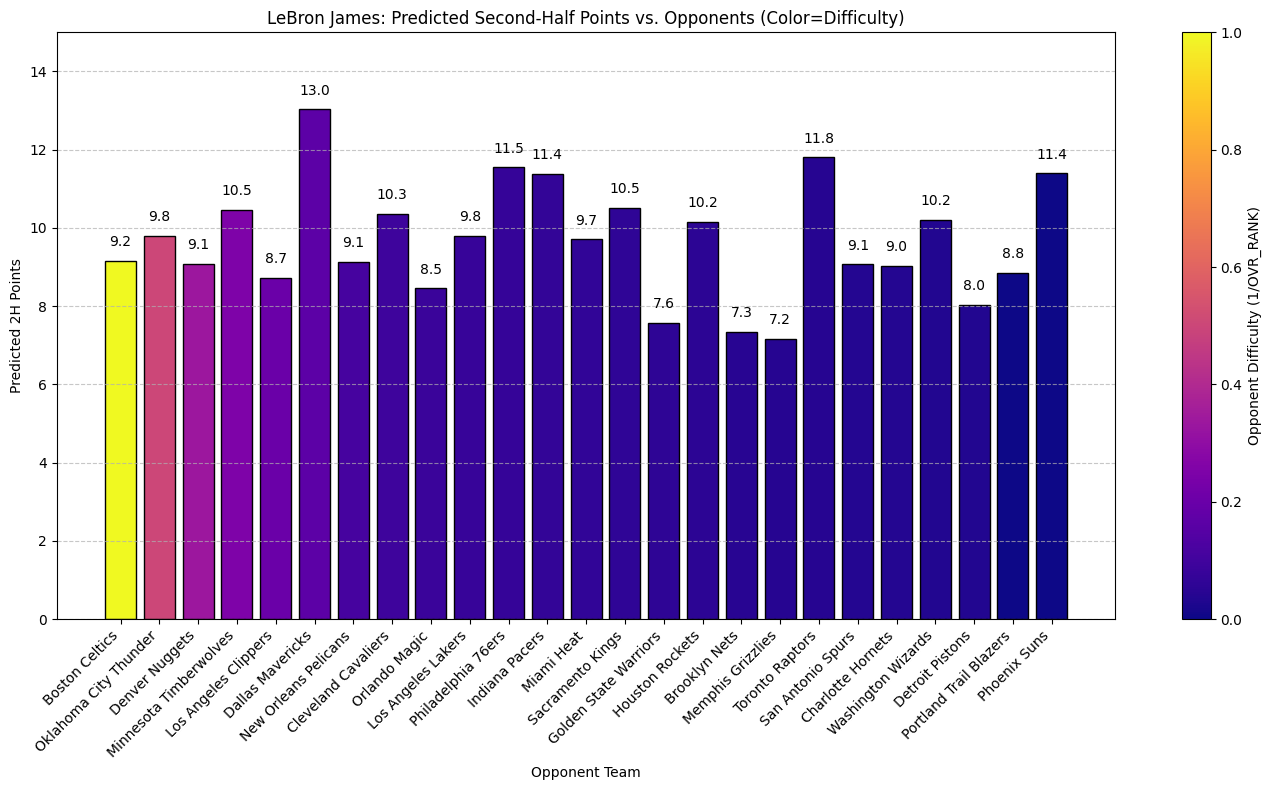

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib
import os
import pathlib

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# -----------------------------------
# Helpers
# -----------------------------------
def find_csv(filename: str) -> pathlib.Path:
    """Look for filename in project root or Datasets/."""
    for candidate in (
        pathlib.Path(filename),
        pathlib.Path("Datasets") / filename
    ):
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"Could not find {filename}")

def load_season_averages() -> pd.DataFrame:
    """Concatenate all per-game CSVs under Datasets/NBA dataset 23-24 (NEW)."""
    folder = pathlib.Path("Datasets") / "NBA dataset 23-24 (NEW)"
    if not folder.exists():
        raise FileNotFoundError(f"{folder} not found.")
    dfs = []
    for f in folder.glob("*.csv"):
        df = pd.read_csv(f)
        if "Player" in df.columns:
            df = df.rename(columns={"Player": "PLAYER_NAME"})
        dfs.append(df)
    season_df = pd.concat(dfs, ignore_index=True)
    return season_df.rename(columns={
        "MP":   "MP_per_game",
        "PTS":  "PTS_per_game",
        "AST":  "AST_per_game",
        "TRB":  "TRB_per_game",
        "eFG%": "eFG_pct"
    })[["PLAYER_NAME","MP_per_game","PTS_per_game","AST_per_game","TRB_per_game","eFG_pct"]]

# -----------------------------------
# Team-code → full name map
# -----------------------------------
team_name_map = {
    "ATL":"Atlanta Hawks","BOS":"Boston Celtics","BKN":"Brooklyn Nets",
    "CHA":"Charlotte Hornets","CHI":"Chicago Bulls","CLE":"Cleveland Cavaliers",
    "DAL":"Dallas Mavericks","DEN":"Denver Nuggets","DET":"Detroit Pistons",
    "GSW":"Golden State Warriors","HOU":"Houston Rockets","IND":"Indiana Pacers",
    "LAC":"Los Angeles Clippers","LAL":"Los Angeles Lakers","MEM":"Memphis Grizzlies",
    "MIA":"Miami Heat","MIL":"Milwaukee Bucks","MIN":"Minnesota Timberwolves",
    "NOP":"New Orleans Pelicans","NYK":"New York Knicks","OKC":"Oklahoma City Thunder",
    "ORL":"Orlando Magic","PHI":"Philadelphia 76ers","PHX":"Phoenix Suns",
    "POR":"Portland Trail Blazers","SAC":"Sacramento Kings","SAS":"San Antonio Spurs",
    "TOR":"Toronto Raptors","UTA":"Utah Jazz","WAS":"Washington Wizards"
}

# -----------------------------------
# Read shot-chart & ranking data
# -----------------------------------
shots_csv   = find_csv("23-24 NBA dataset.csv")
ranking_csv = find_csv("23-24 NBA RANKING.csv")

nba_df     = pd.read_csv(shots_csv)
ranking_df = pd.read_csv(ranking_csv)

# enforce dtypes
for c in ['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']:
    nba_df[c] = nba_df[c].astype(int)
for c in ['SHOT_TYPE','PLAYER_NAME','TEAM_NAME','HOME_TEAM_NAME','AWAY_TEAM_NAME','LOCATION']:
    nba_df[c] = nba_df[c].astype(str)

# determine opponent & home_flag
nba_df['OPPONENT_TEAM'] = (
    nba_df['AWAY_TEAM_NAME']
    .where(nba_df['TEAM_NAME']==nba_df['HOME_TEAM_NAME'],
           nba_df['HOME_TEAM_NAME'])
    .str.strip()
)
nba_df['OPPONENT_TEAM_FULL'] = (
    nba_df['OPPONENT_TEAM']
    .map(team_name_map)
    .fillna(nba_df['OPPONENT_TEAM'])
)
nba_df['home_flag'] = (nba_df['LOCATION']=='Home').astype(int)

# keep only shot attempts & compute POINTS
shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG']==1].copy()
shots['POINTS'] = np.where(
    (shots['SHOT_MADE_FLAG']==1)&(shots['SHOT_TYPE']=='3PT'), 3,
    np.where(shots['SHOT_MADE_FLAG']==1, 2, 0)
)

# -----------------------------------
# First- vs Second-Half Aggregation
# -----------------------------------
grouped = shots.groupby(
    ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL','PERIOD']
).agg(
    attempts=('SHOT_ATTEMPTED_FLAG','sum'),
    made    =('SHOT_MADE_FLAG','sum'),
    points  =('POINTS','sum')
).reset_index()

first_half = (
    grouped[grouped['PERIOD'].isin([1,2])]
    .groupby(['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL'])
    .agg(
        first_half_attempts=('attempts','sum'),
        first_half_made     =('made','sum'),
        first_half_points   =('points','sum')
    )
    .reset_index()
)

second_half = (
    grouped[grouped['PERIOD'].isin([3,4])]
    .groupby(['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL'])
    .agg(second_half_points=('points','sum'))
    .reset_index()
)

game_player_data = pd.merge(
    first_half, second_half,
    on=['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL'],
    how='inner'
)
game_player_data['first_half_fg_pct'] = np.where(
    game_player_data['first_half_attempts']>0,
    game_player_data['first_half_made']/game_player_data['first_half_attempts'],
    0
)

# -----------------------------------
# Opponent Difficulty
# -----------------------------------
ranking_df['TEAM_NAME'] = ranking_df['TEAM_NAME'].str.strip()
game_player_data = pd.merge(
    game_player_data, ranking_df,
    left_on='OPPONENT_TEAM_FULL', right_on='TEAM_NAME', how='left'
)
game_player_data['opponent_difficulty'] = game_player_data['OVR_RANK'].apply(
    lambda r: 1/r if r>0 else 0
)

# -----------------------------------
# Filter to your player (e.g. LeBron)
# -----------------------------------
player_name = "LeBron James"
player_df   = game_player_data[
    game_player_data['PLAYER_NAME'].str.upper()==player_name.upper()
]
if player_df.empty:
    raise ValueError(f"No data for {player_name}")

# extra first-half features by opponent
lh = shots[
    (shots['PLAYER_NAME'].str.upper()==player_name.upper()) &
    (shots['PERIOD'].isin([1,2]))
]
extra = lh.groupby('OPPONENT_TEAM_FULL').agg(
    avg_shot_distance=('SHOT_DISTANCE','mean'),
    pct_3pt_attempts =('SHOT_TYPE', lambda s:(s=='3PT').mean()),
    home_flag_feat   =('home_flag','max')
).rename(columns={'home_flag_feat':'home_flag'}).reset_index()

# opponent-level summary
opp = (
    player_df.groupby('OPPONENT_TEAM_FULL')
    .agg(
        first_half_attempts =('first_half_attempts','mean'),
        first_half_made     =('first_half_made','mean'),
        first_half_points   =('first_half_points','mean'),
        first_half_fg_pct   =('first_half_fg_pct','mean'),
        opponent_difficulty =('opponent_difficulty','mean'),
        second_half_points  =('second_half_points','mean')
    )
    .reset_index()
)
opp = pd.merge(opp, extra, on='OPPONENT_TEAM_FULL', how='left')

# -----------------------------------
# Merge in season averages for the player
# -----------------------------------
season_df    = load_season_averages()
player_stats = season_df[
    season_df['PLAYER_NAME'].str.upper()==player_name.upper()
]
if player_stats.empty:
    raise ValueError(f"No season stats for {player_name}")
stats = player_stats.iloc[0]
for col in ['MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct']:
    opp[col] = stats[col]

# -----------------------------------
# Prepare features & target
# -----------------------------------
feature_cols = [
    'first_half_attempts','first_half_made','first_half_points','first_half_fg_pct',
    'avg_shot_distance','pct_3pt_attempts','home_flag','opponent_difficulty',
    'MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct'
]
X = opp[feature_cols]
y = opp['second_half_points']

# -----------------------------------
# Pipeline: scale + linear regression
# -----------------------------------
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

pickle_name = 'linear_pipeline.pkl'
if os.path.exists(pickle_name):
    pipeline = joblib.load(pickle_name)
else:
    pipeline.fit(X, y)
    joblib.dump(pipeline, pickle_name)

# predict
opp['predicted_second_half_points'] = pipeline.predict(X)

# -----------------------------------
# Plot predictions
# -----------------------------------
opp = opp.sort_values('opponent_difficulty', ascending=False)
teams      = opp['OPPONENT_TEAM_FULL']
pred_pts   = opp['predicted_second_half_points']
difficulty = opp['opponent_difficulty']

norm   = mpl.colors.Normalize(difficulty.min(), difficulty.max())
cmap   = mpl.cm.plasma
colors = cmap(norm(difficulty))

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(teams, pred_pts, color=colors, edgecolor='black')

for bar in bars:
    y = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, y + 0.3,
            f"{y:.1f}", ha='center', va='bottom')

ax.set_xlabel("Opponent Team")
ax.set_ylabel("Predicted 2H Points")
ax.set_ylim(0, 15)
ax.set_title(f"{player_name}: Predicted Second-Half Points vs. Opponents (Color=Difficulty)")
ax.set_xticklabels(teams, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Opponent Difficulty (1/OVR_RANK)")

plt.tight_layout()
plt.show()

Nba Player's Predicted Second Half Points Vs. Actual

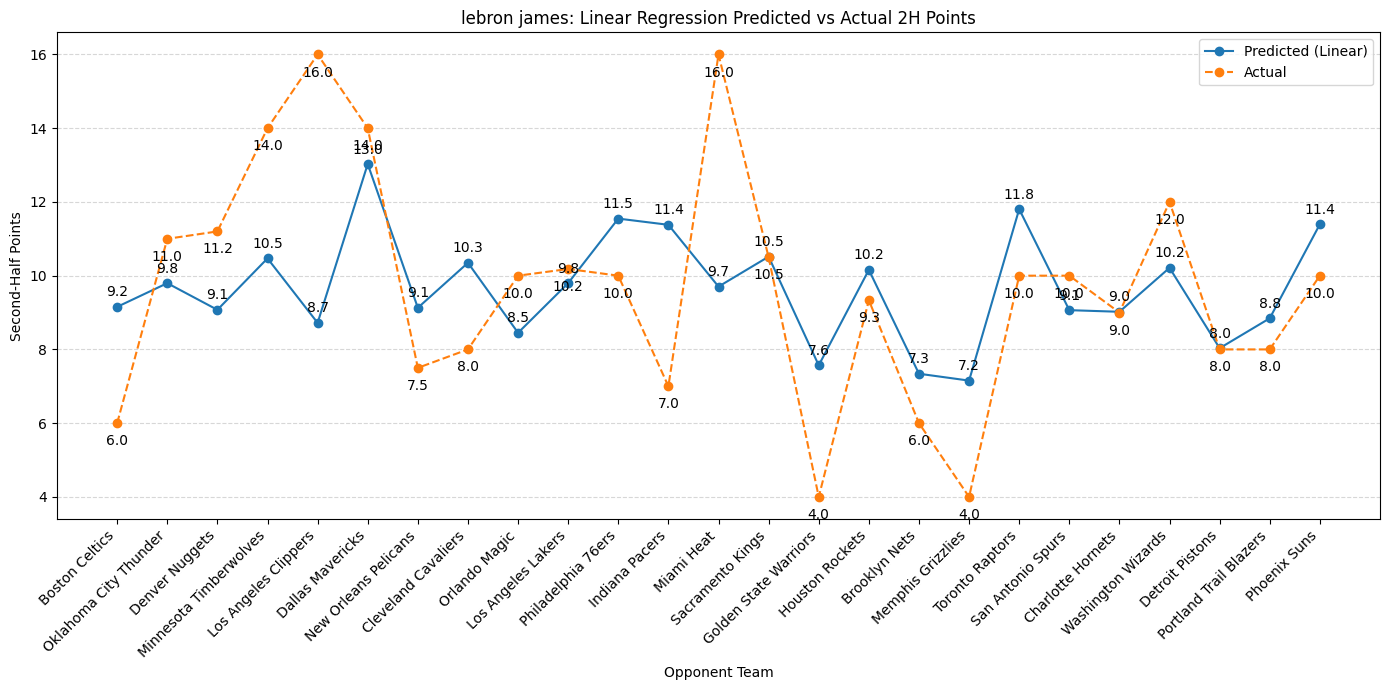

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# -----------------------------------
# Helpers
# -----------------------------------
def find_csv(filename: str) -> pathlib.Path:
    """Look for filename in project root or Datasets/."""
    for p in (pathlib.Path(filename), pathlib.Path("Datasets")/filename):
        if p.exists():
            return p
    raise FileNotFoundError(f"Could not find {filename}")

def load_season_averages() -> pd.DataFrame:
    """Load all per-game CSVs under Datasets/NBA dataset 23-24 (NEW)."""
    folder = pathlib.Path("Datasets") / "NBA dataset 23-24 (NEW)"
    if not folder.exists():
        raise FileNotFoundError(f"{folder} not found.")
    dfs = []
    for f in folder.glob("*.csv"):
        df = pd.read_csv(f)
        if "Player" in df.columns:
            df = df.rename(columns={"Player": "PLAYER_NAME"})
        dfs.append(df)
    season_df = pd.concat(dfs, ignore_index=True)
    return season_df.rename(columns={
        "MP":   "MP_per_game",
        "PTS":  "PTS_per_game",
        "AST":  "AST_per_game",
        "TRB":  "TRB_per_game",
        "eFG%": "eFG_pct"
    })[["PLAYER_NAME","MP_per_game","PTS_per_game","AST_per_game","TRB_per_game","eFG_pct"]]

# -----------------------------------
# Team-code ↔ full-name maps
# -----------------------------------
team_name_map = {
    "ATL":"Atlanta Hawks","BOS":"Boston Celtics","BKN":"Brooklyn Nets",
    "CHA":"Charlotte Hornets","CHI":"Chicago Bulls","CLE":"Cleveland Cavaliers",
    "DAL":"Dallas Mavericks","DEN":"Denver Nuggets","DET":"Detroit Pistons",
    "GSW":"Golden State Warriors","HOU":"Houston Rockets","IND":"Indiana Pacers",
    "LAC":"Los Angeles Clippers","LAL":"Los Angeles Lakers","MEM":"Memphis Grizzlies",
    "MIA":"Miami Heat","MIL":"Milwaukee Bucks","MIN":"Minnesota Timberwolves",
    "NOP":"New Orleans Pelicans","NYK":"New York Knicks","OKC":"Oklahoma City Thunder",
    "ORL":"Orlando Magic","PHI":"Philadelphia 76ers","PHX":"Phoenix Suns",
    "POR":"Portland Trail Blazers","SAC":"Sacramento Kings","SAS":"San Antonio Spurs",
    "TOR":"Toronto Raptors","UTA":"Utah Jazz","WAS":"Washington Wizards"
}

# -----------------------------------
# Load or train Linear model & scaler
# -----------------------------------
model_path  = "linear_performance_predictor.pkl"
scaler_path = "linear_scaler.pkl"
if os.path.exists(model_path) and os.path.exists(scaler_path):
    model  = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
else:
    # we'll train after we build X and y below
    model = None
    scaler = None

# -----------------------------------
# Read shot-chart & ranking data
# -----------------------------------
shots_csv   = find_csv("23-24 NBA dataset.csv")
ranking_csv = find_csv("23-24 NBA RANKING.csv")

nba_df     = pd.read_csv(shots_csv)
ranking_df = pd.read_csv(ranking_csv)

# enforce dtypes
for c in ['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']:
    nba_df[c] = nba_df[c].astype(int)
for c in ['SHOT_TYPE','PLAYER_NAME','TEAM_NAME','HOME_TEAM_NAME','AWAY_TEAM_NAME','LOCATION']:
    nba_df[c] = nba_df[c].astype(str)

# determine opponent & home_flag
nba_df['OPPONENT_TEAM'] = np.where(
    nba_df['TEAM_NAME']==nba_df['HOME_TEAM_NAME'],
    nba_df['AWAY_TEAM_NAME'],
    nba_df['HOME_TEAM_NAME']
)
nba_df['OPPONENT_TEAM_FULL'] = (
    nba_df['OPPONENT_TEAM']
    .map(team_name_map)
    .fillna(nba_df['OPPONENT_TEAM'])
)
nba_df['home_flag'] = (nba_df['LOCATION']=='Home').astype(int)

# compute POINTS on shot attempts only
shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG']==1].copy()
shots['POINTS'] = np.where(
    (shots['SHOT_MADE_FLAG']==1)&(shots['SHOT_TYPE']=='3PT'), 3,
    np.where(shots['SHOT_MADE_FLAG']==1, 2, 0)
)

# -----------------------------------
# First vs Second half aggregation
# -----------------------------------
grouped = shots.groupby(
    ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL','PERIOD']
).agg(
    attempts=('SHOT_ATTEMPTED_FLAG','sum'),
    made    =('SHOT_MADE_FLAG','sum'),
    points  =('POINTS','sum')
).reset_index()

first = grouped[grouped['PERIOD'].isin([1,2])].groupby(
    ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL']
).agg(
    first_half_attempts=('attempts','sum'),
    first_half_made     =('made','sum'),
    first_half_points   =('points','sum')
).reset_index()

second = grouped[grouped['PERIOD'].isin([3,4])].groupby(
    ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL']
).agg(
    second_half_points=('points','sum')
).reset_index()

game_data = first.merge(
    second,
    on=['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL'],
    how='inner'
)
game_data['first_half_fg_pct'] = np.where(
    game_data['first_half_attempts']>0,
    game_data['first_half_made']/game_data['first_half_attempts'],
    0
)

# -----------------------------------
# Opponent difficulty
# -----------------------------------
ranking_df['TEAM_NAME'] = ranking_df['TEAM_NAME'].str.strip()
game_data = game_data.merge(
    ranking_df, left_on='OPPONENT_TEAM_FULL', right_on='TEAM_NAME', how='left'
)
game_data['opponent_difficulty'] = game_data['OVR_RANK'].apply(lambda r: 1/r if r>0 else 0)

# -----------------------------------
# Prompt user & filter to player
# -----------------------------------
player = input("Enter Player Name: ").strip()
pf = game_data[game_data['PLAYER_NAME'].str.upper()==player.upper()]
if pf.empty:
    raise SystemExit(f"No data for {player}")

# extra first-half features by opponent
extra = shots[
    (shots['PLAYER_NAME'].str.upper()==player.upper()) &
    (shots['PERIOD'].isin([1,2]))
].groupby('OPPONENT_TEAM_FULL').agg(
    avg_shot_distance=('SHOT_DISTANCE','mean'),
    pct_3pt_attempts =('SHOT_TYPE', lambda s:(s=='3PT').mean()),
    home_flag_feat   =('home_flag','max')
).rename(columns={'home_flag_feat':'home_flag'}).reset_index()

opp = pf.groupby('OPPONENT_TEAM_FULL').agg(
    first_half_attempts=('first_half_attempts','mean'),
    first_half_made     =('first_half_made','mean'),
    first_half_points   =('first_half_points','mean'),
    first_half_fg_pct   =('first_half_fg_pct','mean'),
    opponent_difficulty =('opponent_difficulty','mean'),
    second_half_points  =('second_half_points','mean')
).reset_index().merge(extra, on='OPPONENT_TEAM_FULL', how='left')

# -----------------------------------
# Merge in season averages
# -----------------------------------
season_df    = load_season_averages()
player_stats = season_df[season_df['PLAYER_NAME'].str.upper()==player.upper()]
if player_stats.empty:
    raise ValueError(f"No season stats for {player}")
stats = player_stats.iloc[0]
for col in ['MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct']:
    opp[col] = stats[col]

# -----------------------------------
# Prepare features & linear regression
# -----------------------------------
feature_cols = [
    'first_half_attempts','first_half_made','first_half_points','first_half_fg_pct',
    'avg_shot_distance','pct_3pt_attempts','home_flag','opponent_difficulty',
    'MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct'
]
X = opp[feature_cols]
y = opp['second_half_points']

if model is None or scaler is None:
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    model  = LinearRegression().fit(X_scaled, y)
    joblib.dump(model,  model_path)
    joblib.dump(scaler, scaler_path)

# predict
X_scaled = scaler.transform(X)
opp['predicted_second_half_points'] = model.predict(X_scaled)

# -----------------------------------
# Plot Predicted vs Actual
# -----------------------------------
opp = opp.sort_values('opponent_difficulty', ascending=False).reset_index(drop=True)
teams     = opp['OPPONENT_TEAM_FULL']
predicted = opp['predicted_second_half_points']
actual    = opp['second_half_points']
x         = np.arange(len(teams))

plt.figure(figsize=(14,7))
plt.plot(x, predicted, marker='o', linestyle='-', label='Predicted (Linear)')
plt.plot(x, actual,    marker='o', linestyle='--', label='Actual')

for i in x:
    plt.text(i, predicted[i]+0.2, f"{predicted[i]:.1f}", ha='center', va='bottom')
    plt.text(i, actual[i]-0.3,    f"{actual[i]:.1f}",    ha='center', va='top')

plt.xticks(x, teams, rotation=45, ha='right')
plt.xlabel("Opponent Team")
plt.ylabel("Second-Half Points")
plt.title(f"{player}: Linear Regression Predicted vs Actual 2H Points")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
